# K均值聚类

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, threshold=16)
%matplotlib inline

## 机器学习实战

In [42]:
data = np.loadtxt('testSet.txt')
data

array([[ 1.659 ,  4.2851],
       [-3.4537,  3.4243],
       [ 4.8381, -1.1515],
       ...,
       [-2.9676,  2.8487],
       [ 4.4793, -1.7648],
       [-4.9056, -2.9111]])

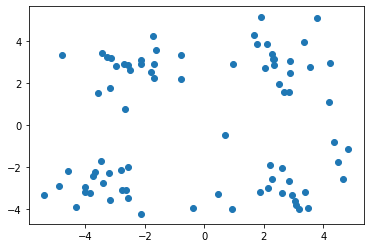

In [6]:
plt.scatter(data[:, 0], data[:, 1])

In [5]:
class KMeans:
    def __init__(self, k):
        self.k = k  # 质心数目
    
    def init_(self, X):
        X_max = np.max(X, axis=0)
        X_min = np.min(X, axis=0)
        m0 = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            m_ = np.random.rand(X.shape[1]) * (X_max - X_min) + X_min
            m0[i] = m_
        return m0
      
    def fit(self, X):
        n_samples, n_features = X.shape
        # 保存聚类的结果, (所属类编号, 样本到所属类中心距离)
        cluster = np.zeros((n_samples, 2)) 
        # 初始化 中心
        m = self.init_(X)

        while True:
            cluster_last = cluster.copy()
            # 计算样本到各中心点距离, 指派到最近的点
            for i in range(n_samples):
                distance = np.sum(np.square(X[i] - m), axis=1)
                min_index = np.argmin(distance)
                cluster[i] = (min_index, distance[min_index])
            
            # 计算新的中心
            # print(m)
            for l in range(self.k):
                m[l] = np.mean(X[cluster[:, 0] == l,:], axis=0)
            if np.all(cluster[:, 0] == cluster_last[:, 0]):
                break
        return m, cluster

In [8]:
clf = KMeans(4)
m, cluster = clf.fit(data)

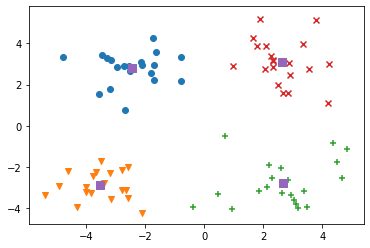

In [9]:
plt.scatter(data[cluster[:, 0]==0, 0], data[cluster[:, 0]== 0, 1], marker='o')
plt.scatter(data[cluster[:, 0]==1, 0], data[cluster[:, 0]== 1, 1], marker='v')
plt.scatter(data[cluster[:, 0]==2, 0], data[cluster[:, 0]== 2, 1], marker='+')
plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='x')
plt.scatter(m[:, 0], m[:, 1], marker='s', s=80)

In [10]:
SSE = np.sum(cluster[:, 1])
SSE

150.62604907269227

### 二分k-means算法
二分k-means算法是为了克服k-means算法收敛于局部最小值的问题,二分k-kmeans算法首先将所有点作为一个簇,然后将该簇一分为二.之后选择其中一个簇继续进行划分,选择哪一个簇进行划分取决于对其划分是否可以最大程度降低SSE值.上述基于SSE的划分过程不断重复,直到得到用户指定的簇数目为止

二分k-means的伪代码形式如下:
* 将所有点看成一个簇
* 当簇数目小于 k 时
* 对于每一个簇
    * 计算总误差
    * 在给定的簇上面进行 KMeans 聚类（k=2）
    * 计算将该簇一分为二之后的总误差
* 选择使得误差最小的那个簇进行划分操作

另一种做法是选择 SSE 最大的簇进行划分，直到簇数目达到用户指定的数目位置。

In [6]:
# 二分 K-Means 聚类算法
class BinMeans:
    def __init__(self, k):
        self.k = k
          
    def choose_best_cluster(self, X, cluster, m):
        # 选择最优的簇进行分类, 
        max_diff = 0
        # 当前所有类别
        m_index = np.unique(cluster[:, 0]).astype(int).tolist()
        cluster_m = []
        for l in m_index:
            data = X[cluster[:, 0]==l, :]
            # 聚类之前的SSE
            sse_before = np.sum(cluster[cluster[:, 0]==l, 1])
            clf = KMeans(2)
            new_m, new_cluster = clf.fit(data)
            # 新的类的编号
            new_cluster[:, 0] += len(m)
            cluster_m.append((new_cluster, new_m))
            # 最大程度降低SSE的值
            diff = sse_before - np.sum(new_cluster[:, 1]) 
            if diff > max_diff:
                best_index = l
                max_diff = diff
        # 添加新的中心点
        m.extend(cluster_m[m_index.index(best_index)][1])
        j = 0
        # 更新每个样本的类别编号和距离中心的距离
        for i in range(len(cluster)):
            if cluster[i, 0] == best_index:
                cluster[i] = cluster_m[m_index.index(best_index)][0][j]
                j += 1
        return cluster, m
            
            
    def fit(self, X):
        n_samples, n_features = X.shape
        # 所有样本分到一个簇中
        m_ = np.mean(X, axis=0)
        m = [m_]
        cluster = np.zeros((n_samples, 2))
        cluster[:, 1] = np.sum(np.square(X - m[0]), axis=1)
        
        while len(np.unique(cluster[:, 0])) < self.k:
            cluster, m = self.choose_best_cluster(X, cluster, m)
            # 对sse最大的簇进行 K-Means聚类(k=2)
        return np.array(m), cluster

In [141]:
clf = BinMeans(4)
m, cluster = clf.fit(data)

In [142]:
m

array([[-0.1036,  0.0543],
       [ 0.0825,  2.948 ],
       [-0.2897, -2.8394],
       [ 2.6508, -2.7902],
       [-3.5397, -2.8938],
       [ 2.6265,  3.1087],
       [-2.4615,  2.7874]])

In [143]:
SSE = np.sum(cluster[:, 1])
SSE

150.62604907269227

In [144]:
np.unique(cluster[:, 0])

array([3., 4., 5., 6.])

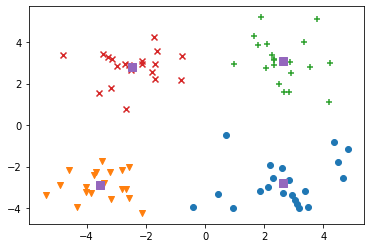

In [146]:
plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='o')
plt.scatter(data[cluster[:, 0]==4, 0], data[cluster[:, 0]== 4, 1], marker='v')
plt.scatter(data[cluster[:, 0]==5, 0], data[cluster[:, 0]== 5, 1], marker='+')
plt.scatter(data[cluster[:, 0]==6, 0], data[cluster[:, 0]== 6, 1], marker='x')
plt.scatter(m[3:, 0], m[3:, 1], marker='s', s=80)

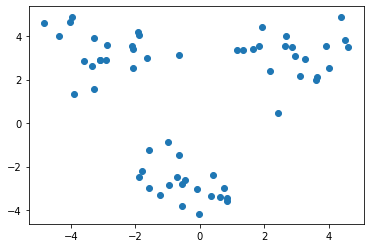

In [4]:
data = np.loadtxt('./testSet2.txt')
plt.scatter(data[:, 0], data[:, 1])

In [29]:
clf_k = KMeans(k=3)
m, cluster = clf_k.fit(data)

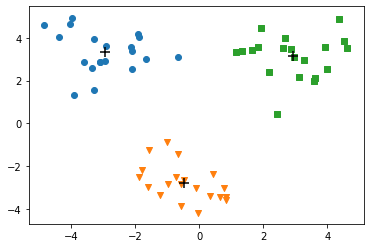

In [30]:

plt.scatter(data[cluster[:, 0]==0, 0], data[cluster[:, 0]== 0, 1], marker='o')
plt.scatter(data[cluster[:, 0]==1, 0], data[cluster[:, 0]== 1, 1], marker='v')
plt.scatter(data[cluster[:, 0]==2, 0], data[cluster[:, 0]== 2, 1], marker='s')
# plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='x')
plt.scatter(m[:, 0], m[:, 1], marker='+', s=100, c='k')

In [31]:
clf_k = BinMeans(k=3)
m, cluster = clf_k.fit(data)

In [32]:
np.unique(cluster[:, 0])

array([2., 3., 4.])

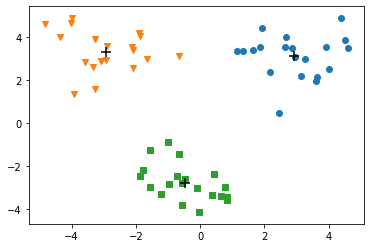

In [33]:
plt.scatter(data[cluster[:, 0]==2, 0], data[cluster[:, 0]== 2, 1], marker='o')
plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='v')
plt.scatter(data[cluster[:, 0]==4, 0], data[cluster[:, 0]== 4, 1], marker='s')
# plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='x')
plt.scatter(m[2:, 0], m[2:, 1], marker='+', s=100, c='k')

## sklearn  KMeans

```
Signature:
make_blobs(
    n_samples=100,
    n_features=2,
    centers=None,
    cluster_std=1.0,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=None,
)
Docstring:
Generate isotropic Gaussian blobs for clustering.

Read more in the :ref:`User Guide <sample_generators>`.
```

In [43]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

blobs, classes = make_blobs(500, centers=3)

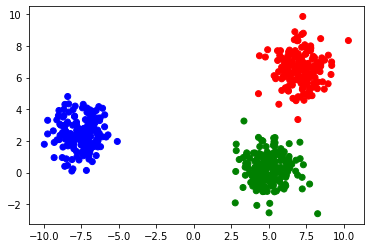

In [44]:
color_map = np.array(['r', 'g', 'b']) 
plt.scatter(blobs[:, 0], blobs[:, 1], color=color_map[classes])

```
class sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10,
                            max_iter=300, tol=0.0001, precompute_distances=’auto’,
                            verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm=’auto’)
```


In [45]:
# 假设已知有3个中心
kmean = KMeans(n_clusters=3)
kmean.fit(blobs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [51]:
classes

array([1, 1, 2, ..., 1, 1, 0])

In [47]:
# 每个样本点的预期标签, 由于 KMeans 不知道类别是什么, 与classes会不一致
kmean.labels_

array([0, 0, 1, ..., 0, 0, 2], dtype=int32)

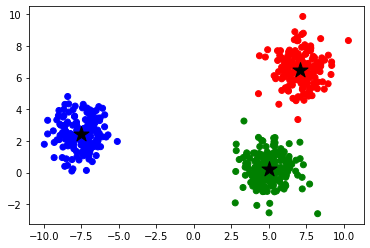

In [50]:
color_map = np.array(['r', 'g', 'b']) 
plt.scatter(blobs[:, 0], blobs[:, 1], color=color_map[classes])
# cluster 中心点坐标
plt.scatter(kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1], marker='*', s=250, color='k')

In [52]:
kmean.predict([[5, -1], [-8, 3], [5, 5]])

array([0, 1, 2], dtype=int32)

In [53]:
# 输出每个点到形心的距离
kmean.transform(blobs[:5])

array([[ 0.3053, 12.5557,  6.3917],
       [ 1.4602, 12.7494,  8.0562],
       [13.4741,  1.1305, 16.2234],
       [ 5.8907, 13.4112,  1.7897],
       [13.4756,  0.7669, 15.9545]])

## 优化形心数量
---
形心难以解释，并且也难以判断是否数量正确。理解你的数据是否是未分类的十分重要，因为这会直接影响我们可用的评估手段。

In [54]:
blobs, classes = make_blobs(500, centers=3)
kmean = KMeans(n_clusters=3)
kmean.fit(blobs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

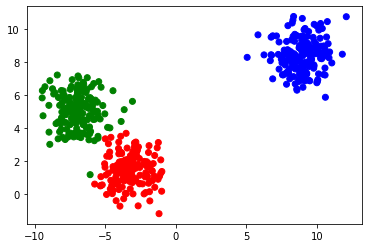

In [62]:
color_map = np.array(['r', 'g', 'b']) 
plt.scatter(blobs[:, 0], blobs[:, 1], color=color_map[classes])

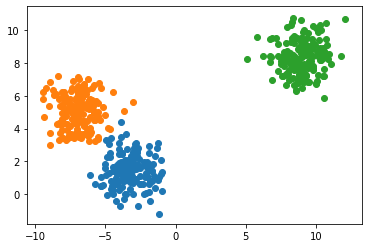

In [66]:
cluster_labels = kmean.labels_
blobs[cluster_labels==2]
plt.scatter(blobs[cluster_labels==2][:, 0], blobs[cluster_labels==2][:, 1])
plt.scatter(blobs[cluster_labels==1][:, 0], blobs[cluster_labels==1][:, 1])
plt.scatter(blobs[cluster_labels==0][:, 0], blobs[cluster_labels==0][:, 1])

首先，我们查看轮廓（Silhouette）距离。轮廓距离是簇内不相似性、最近的簇间不相似性、以及这两个值最大值的比值。它可以看做簇间分离程度的度量。
评估它的相似性
$$s_i = \frac {b_i - a_i}{max(a_i, b_i)}$$
是观测样本$i$的轮廓系数, $a_i是i和同类的所有观测值之间的平均距离, 而b_i是i和不同类的所有观测的平均距离的最小值$

In [60]:
from sklearn import metrics
silhouette_samples = metrics.silhouette_samples(blobs, kmean.labels_)
silhouette_samples

array([0.7616, 0.6251, 0.7339, ..., 0.5636, 0.8617, 0.6798])

In [58]:
np.column_stack((classes[:5], silhouette_samples[:5]))

array([[0.    , 0.7616],
       [1.    , 0.6251],
       [1.    , 0.7339],
       [2.    , 0.8169],
       [0.    , 0.7582]])

(array([  5.,   2.,   5.,   3.,   8.,  19.,  68., 140.,  99., 151.]),
 array([0.0186, 0.1073, 0.196 , 0.2847, 0.3734, 0.4621, 0.5508, 0.6394,
        0.7281, 0.8168, 0.9055]),
 <a list of 10 Patch objects>)

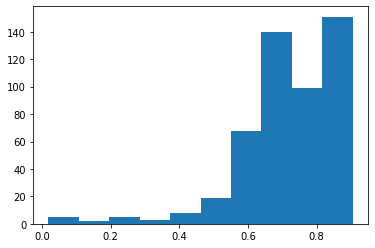

In [59]:
# 数据点到形心的距离分布
plt.hist(silhouette_samples)
# 通常接近 1 的系数越高，分数就越高

In [61]:
# 轮廓系数的均值通常用于描述整个模型的拟合度
silhouette_samples.mean()

0.719168958265358

In [67]:
# 直接获取 轮廓系数的均值
metrics.silhouette_score(blobs, kmean.labels_)

0.719168958265358

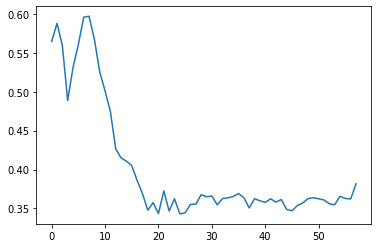

In [69]:
blobs, classes = make_blobs(500, centers=10)
sillhouette_avgs = []
for k in range(2, 60):
    kmean = KMeans(n_clusters=k).fit(blobs)
    sillhouette_avgs.append(metrics.silhouette_score(blobs, kmean.labels_))
plt.plot(sillhouette_avgs)

轮廓均值随着形心数量的变化情况. 最优的数量和实际的数量不一致, 这就是聚类的实际情况，十分普遍，我们不能获得正确的簇数量，我们只能估计簇数量的近似值

## 评估聚类的正确性
---
簇已知条件下的 KMeans 评估

In [85]:
blobs, classes = make_blobs(500, centers=3)
kmean = KMeans(n_clusters=3).fit(blobs)

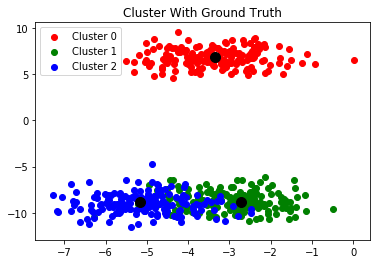

In [86]:
colors = ['r', 'g', 'b']
for i in range(3):
    p = blobs[classes==i]
    plt.scatter(p[:, 0], p[:, 1], label=f'Cluster {i}', color=colors[i])
plt.legend()
plt.scatter(kmean.cluster_centers_[:, 0],
               kmean.cluster_centers_[:, 1], s=100,
               color='black',
               label='Centers') 
plt.title("Cluster With Ground Truth") 
plt.savefig('2020-1-11_1')

In [87]:
kmean.labels_

array([0, 0, 0, ..., 0, 1, 1], dtype=int32)

In [88]:
classes

array([2, 2, 2, ..., 2, 0, 0])

In [101]:
# 原始classes 变换类别编号
labels = kmean.labels_.copy()
labels[kmean.labels_==2] = 1  # 2->0
labels[kmean.labels_==0] = 2  # 0->1
labels[kmean.labels_==1] = 0  # 1->2
labels

array([2, 2, 2, ..., 2, 0, 0], dtype=int32)

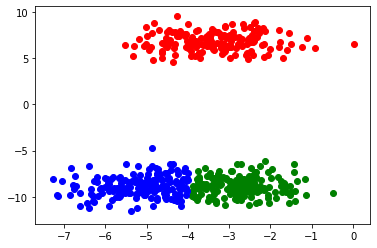

In [102]:
# 聚类的结果
for i in range(3):
    p = blobs[labels==i]
    plt.scatter(p[:, 0], p[:, 1], label=f'Cluster {i}', color=colors[i])

**准确度**

In [103]:
# 各类别的准确度
for i in range(3):
    print((classes == labels)[classes==i].astype(int).mean())

1.0
0.8263473053892215
0.8674698795180723


第二个相似性度量是**互信息**（ mutual information score）得分。

分数靠近 0，就说明标签的分配可能不是按照相似过程生成的。但是分数靠近 1，就说明两个标签有很强的一致性。

In [105]:
metrics.normalized_mutual_info_score(classes, kmean.labels_)

/home/ulysses/.local/lib/python3.8/site-packages/sklearn/metrics/cluster/supervised.py:856: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  warnings.warn("The behavior of NMI will change in version 0.22. "


0.7411541350543571

**惯性**（inertia）度量. 
惯性是每个数据点和它所分配的簇的平方差之和

In [106]:
kmean.inertia_

883.3046531502307